<a href="https://colab.research.google.com/github/orion29/Spoken-Language-Identification/blob/master/SpokenLanguageTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPOKEN LANGUAGE IDENTIFICATION**



In [ ]:
!pip install -q soundfile
import soundfile as sf
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import librosa
from librosa import display



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import numpy
import pandas as pd
from torch.optim import Adam

import time
import torch.nn.functional as F

directory='gdrive/My Drive/spoken/'




In [ ]:
lene=0
label = []
for filename in os.listdir(directory):
    lene=lene+1
    label.append(filename[:2])

In [ ]:
file = []
for filename in os.listdir(directory):
    file.append(filename)

## **Reading Audio Files**

In [ ]:

mel=[]
min=0.0
max=255.0
for i in range(lene):
  data, samplerate = sf.read(directory+file[i])
  mels =librosa.feature.melspectrogram(data, sr=samplerate)
  mels = numpy.log(mels + 1e-9)
  
  X_std = (mels - mels.min()) / (mels.max() - mels.min())*255
  


  img = X_std.astype(numpy.uint8)
  img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
  img = 255-img
  mel.append(img) 
  if(i%1000==0):
    print(i)



In [ ]:
from google.colab import files
import pickle
with open("spectrum.txt", "wb") as fp:   #Pickling
  pickle.dump(mel, fp)
 
files.download('spectrum.txt')

In [ ]:
import pickle
with open("gdrive/My Drive/spectrum (1).txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)

In [ ]:

data = {'filename':file,
        'language':label,
        'spectrum':b}
df = pd.DataFrame(data)
print(df.head())


                                            filename  ...                                           spectrum
0  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[147, 142, 142, 161, 162, 128, 122, 142, 176,...
1  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[137, 134, 134, 149, 149, 122, 118, 133, 160,...
2  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[136, 133, 132, 146, 148, 121, 116, 132, 159,...
3  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[165, 160, 160, 182, 183, 144, 137, 159, 196,...
4  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[158, 155, 155, 176, 175, 138, 132, 154, 189,...

[5 rows x 3 columns]


In [ ]:
df=df.drop([1978,2026,3616])
df = df.reset_index(drop=True)

In [ ]:
import sklearn
for i in range(50):
   df = sklearn.utils.shuffle(df)
df = df.reset_index(drop=True)
print(df.head())


                                            filename  ...                                           spectrum
0  de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...  ...  [[173, 170, 159, 160, 160, 157, 163, 164, 151,...
1  es_f_53b555eab2b3baada380f7d3ede20b20.fragment...  ...  [[231, 237, 238, 242, 234, 234, 241, 242, 244,...
2  en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...  ...  [[196, 209, 229, 213, 203, 211, 232, 216, 212,...
3  es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...  ...  [[230, 236, 243, 245, 246, 247, 246, 245, 248,...
4  es_f_53b555eab2b3baada380f7d3ede20b20.fragment...  ...  [[244, 247, 250, 251, 250, 248, 247, 248, 249,...

[5 rows x 3 columns]


In [ ]:
df = pd.concat([df,pd.get_dummies(df['language'], prefix='lang')],axis=1)

In [ ]:
def onehotcode(i):
  y=torch.tensor([df['lang_de'][i],df['lang_en'][i],df['lang_es'][i]])
  y=y.float()
  return y

## **Batch Formation**

In [ ]:
data=[]
output=[]
for i in range(0,10000,5):
  for j in range(i,i+5,1):
    if j%5 == 0:
      t=torch.tensor(df['spectrum'][j].reshape(1,1,128,313))
      y=onehotcode(j).reshape(1,3)
   
    else:
        t = torch.cat((torch.tensor(df['spectrum'][j].reshape(1,1,128,313)), t), 0)
        y=torch.cat((onehotcode(j).reshape(1,3),y),0)
  t=torch.tensor(t,dtype=torch.float32)
  data.append(t)
  output.append(y)
len(data)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


2000

## **Neural Network Architecture**

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,size):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, 1, 1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=(2,2))
        )
        
        
        

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        
        
        
        return x
      


class ConvBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.Dropout(0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=(2,2))
        )
        
        
        

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        
        
        return x
      
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conva = nn.Sequential(
            ConvBlock1(in_channels=1, out_channels=16),
        ) 
        self.convb = nn.Sequential(
            ConvBlock(in_channels=16, out_channels=32,size=5),
        )
        self.convc = nn.Sequential(
            ConvBlock(in_channels=32, out_channels=32,size=3),
            
        )
       
        self.rnn = nn.GRU(3456, 128, 1,batch_first=True)
        self.fc =  nn.Linear(128, 3)
           
        
        self.sig = nn.Sigmoid()
      
        

    def forward(self, x):
        hidden = self.init_hidden()
        
        x = self.conva(x)
        
        x = self.convb(x)
        
        x = self.convc(x)
        
        x = self.convc(x)
       
        
        
        x, hidden = self.rnn(x.view(5,1,3456),hidden)
        
        x=x.reshape(5,128)
        
       
        x = self.fc(x)
        
        x=self.sig(x)
        return x
    
    def init_hidden(self):
        
        hidden = torch.zeros(1,5,128)
        hidden=hidden.cuda()
        return hidden


## **Training Details**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
num_epochs = 10
   
    
lr = 1e-4
eta_min = 1e-5
t_max = 10

    
    
    
model = Classifier().to(device)
criterion = nn.BCELoss().to(device)
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)



## **Training Function**

In [ ]:
a=[]
b=[]
for epoch in range(2):
    start_time = time.time()
    model.train()
    avg_loss = 0.
    z=0
    for i in range(1900):
            model.zero_grad()
            
            
            
            preds = model(data[i].to(device))
            
    
            loss = criterion(preds, output[i].to(device))
            
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / 1900
            
            aprox = torch.round(preds.squeeze())
            aprox=aprox.to(device)
            for k in range(5):
              
                if torch.all(torch.eq(aprox[k], output[i].to(device)[k])):
                  z=z+1
            
    model.eval()
      
    
      
        
        
    

    if (epoch + 1) % 1 == 0:
        elapsed = time.time() - start_time
        print('Epoch :',epoch+1, ' avg_train_loss:' ,avg_loss ,  'time:' ,elapsed,'Training Accuracy:',z*100/(9500)  )
        a.append(avg_loss)
        
    l=0
    final=0
    m=0
    if (epoch+1) % 1 == 0:
      for j in range(1900,1950,1):
            l=l+1
            
            preds = model(data[j].to(device))
            
            y=output[j]
            y=y.to(device)
            loss = criterion(preds, y)
            final+=loss.item()/50
            aprox = torch.round(preds.squeeze())
            aprox=aprox.to(device)
            for k in range(5):
              
              if torch.all(torch.eq(aprox[k],y[k])):
                m=m+1
      
      
      print("Validation Loss :",final)
      print("Validation Accuracy :",(m*100)/(250),"%")
      b.append(final)

         
    

Epoch : 1  avg_train_loss: 0.019975361037435708 time: 16.239071130752563 Training Accuracy: 98.88421052631578
Validation Loss : 0.36472500759176907
Validation Accuracy : 78.4 %
Epoch : 2  avg_train_loss: 0.01488054887822057 time: 16.323368549346924 Training Accuracy: 99.22105263157894
Validation Loss : 0.23191924410872164
Validation Accuracy : 85.6 %


## **Training Loss And Validation Loss**

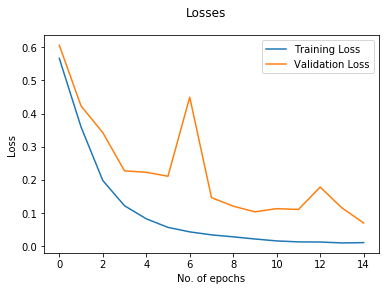

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(a)
plt.plot(b)
fig.suptitle('Losses')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')        
plt.legend(['Training Loss', 'Validation Loss'])

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

## **Testing**

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
PATH = "model.pt"
device = torch.device('cpu')
model = Classifier()
model.load_state_dict(torch.load(PATH, map_location=torch.device("cpu")))

<All keys matched successfully>

In [ ]:
preds = model(data[1999])
            
aprox = torch.round(preds.squeeze())
print(aprox)
for l in range(5):
  print("For file",i*5)
  if aprox[l]==torch.tensor([0,0,1]):
    print('French')
  elif aprox[l]==torch.tensor([0,1,0]):
    print('English')
  else:
    print('German')